# 🧭 Clasificación de hojas de papa con CNNs (Transfer Learning)

En este notebook se entrena un modelo basado en **MobileNetV2** para clasificar imágenes de hojas de papa en distintas categorías.

Se utiliza **Transfer Learning**, lo que permite aprovechar pesos preentrenados en grandes datasets (como ImageNet) y adaptarlos a nuestro problema específico, reduciendo tiempo de entrenamiento y mejorando la precisión.


In [18]:
!pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### 📁 2. Importación de librerías
Se cargan las librerías necesarias para el procesamiento de imágenes, la construcción del modelo y la evaluación del desempeño.

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf


### 🧩 3. Configuración del dataset
Las imágenes redimensionadas del directorio `../data/2_data_resize/` se organizan en tres subconjuntos:

- **Entrenamiento (train):** 70%
- **Validación (val):** 20%
- **Prueba (test):** 10%

Cada carpeta contiene subdirectorios con las clases correspondientes (por ejemplo: `Early_Blight`, `Late_Blight`, `Healthy`).


In [20]:
# Directorios
train_dir = "../data/2_data_resize/"  # Dataset redimensionado

# Parámetros
img_size = (224, 224)
batch_size = 32

# Generador de datos (aumentación + normalización)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Cargar conjuntos de entrenamiento y validación
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)


Found 2464 images belonging to 7 classes.
Found 612 images belonging to 7 classes.


### ⚙️ 4. Preprocesamiento y data generators
Se utilizan los `ImageDataGenerator` de *Keras* para:

- Escalar los valores de píxel a rango [0, 1].
- Aplicar pequeñas **transformaciones aleatorias** (rotación, desplazamiento, zoom) para aumentar la robustez del modelo frente a variaciones en las hojas.


In [21]:
# Cargar modelo base preentrenado (sin la parte superior)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar la mayoría de las capas y dejar las últimas 40 entrenables (fine-tuning)
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

# Bloque superior personalizado
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(7, activation='softmax')(x)  # 7 clases

# Construcción del modelo final
model = Model(inputs=base_model.input, outputs=outputs)

# Compilación con tasa de aprendizaje baja (importante para transfer learning)
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,046,983 (11.62 MB)

 Trainable params: 2,470,535 (9.42 MB)

 Non-trainable params: 576,448 (2.20 MB)

### 🧠 5. Definición del modelo base
Se carga el modelo **MobileNetV2** preentrenado con *ImageNet*, eliminando su parte superior (clasificador original), para agregar un nuevo bloque denso adaptado a nuestro número de clases.  

El modelo base se congela inicialmente (sus pesos no se modifican) para evitar el sobreajuste en las primeras etapas del entrenamiento.


In [22]:
# Callbacks para estabilidad
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]

# Entrenamiento
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.1636 - loss: 2.2116 - val_accuracy: 0.2304 - val_loss: 1.9045 - learning_rate: 1.0000e-05
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.2415 - loss: 1.9389 - val_accuracy: 0.2533 - val_loss: 1.8201 - learning_rate: 1.0000e-05
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.2918 - loss: 1.8264 - val_accuracy: 0.2958 - val_loss: 1.7224 - learning_rate: 1.0000e-05
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.3340 - loss: 1.6933 - val_accuracy: 0.3203 - val_loss: 1.6458 - learning_rate: 1.0000e-05
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.3693 - loss: 1.6363 - val_accuracy: 0.3627 - val_loss: 1.5775 - learning_rate: 1.0000e-05
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.4054 - loss: 1.5507 - val_accuracy: 0.3513 - val_loss: 1.5300 - learning_rate: 1.0000e-05
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.4533 -

### 📈 6. Visualización de resultados
Se grafican las curvas de **precisión** y **pérdida** (train vs validation) para analizar la evolución del aprendizaje.

Esto permite verificar si el modelo converge correctamente o presenta sobreajuste.


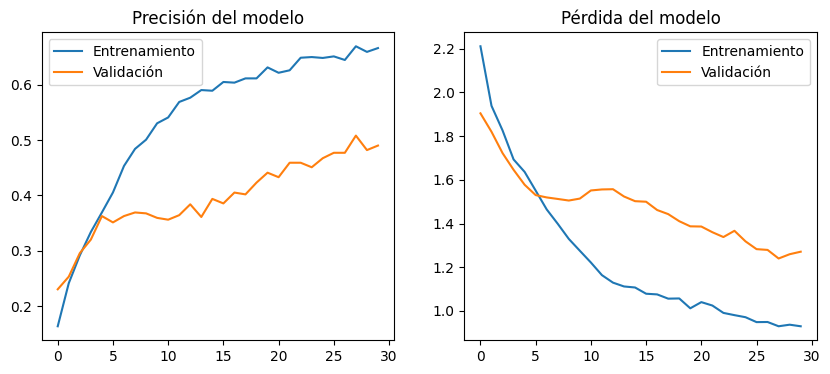

In [23]:
# Curvas de entrenamiento
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.legend()
plt.show()


### 🧪 7. Evaluación final
El modelo se evalúa sobre el conjunto de prueba para obtener su **precisión final** y se genera una **matriz de confusión** para visualizar los errores de clasificación entre las clases de hojas.


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 581ms/step - accuracy: 0.5065 - loss: 1.2563
Precisión final en validación: 0.5065
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step


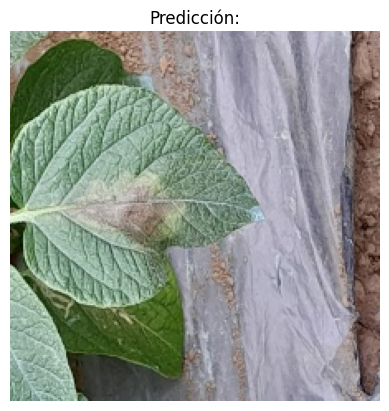

In [24]:
# Evaluar modelo
val_loss, val_acc = model.evaluate(val_gen)
print(f"Precisión final en validación: {val_acc:.4f}")

# Mostrar una predicción aleatoria
import random
img_path, label = random.choice(val_gen.filepaths), None

img = plt.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.title("Predicción:")

# Preparar imagen
from tensorflow.keras.preprocessing import image
x = image.load_img(img_path, target_size=img_size)
x = image.img_to_array(x) / 255.0
x = np.expand_dims(x, axis=0)

pred = model.predict(x)
pred_class = np.argmax(pred)
classes = list(train_gen.class_indices.keys())
plt.xlabel(f"Clase predicha: {classes[pred_class]}")
plt.show()


### 💾 8. Guardado del modelo
Finalmente, el modelo entrenado se guarda en la ruta:

In [25]:
model.save("../models/potato_leaf_cnn.h5")
print("Modelo guardado correctamente.")


Modelo guardado correctamente.
